# Diabetic Retinopathy

## Using Multiclass classification

### 1. Loading of the libraries, dataset and creating dataloaders

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from PIL import Image

root_path = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered"

df = pd.read_csv(os.path.join(root_path, 'train.csv'))
root_dir = os.path.join(root_path, 'gaussian_filtered_images', 'gaussian_filtered_images')

label_mapping = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

df['label_folder'] = df['diagnosis'].map(label_mapping)

train_intermediate, val = train_test_split(df, test_size=0.15, stratify=df['diagnosis'])
train, test = train_test_split(train_intermediate, test_size=0.15 / (1 - 0.15), stratify=train_intermediate['diagnosis'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images within 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Random color adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization based on ImageNet statistics
])

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx, 0] + ".png"
        diagnosis = self.df.iloc[idx, 1]
        label_folder = label_mapping[diagnosis]

        img_path = os.path.join(self.root_dir, label_folder, image_id)

        if not os.path.isfile(img_path):
            print(f"File not found: {img_path}")
            raise FileNotFoundError(f"File not found: {img_path}")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, diagnosis

train_dataset = DiabeticRetinopathyDataset(train, root_dir, transform)
val_dataset = DiabeticRetinopathyDataset(val, root_dir, transform)
test_dataset = DiabeticRetinopathyDataset(test, root_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 2. Custom CNN Architecture

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding='valid')
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding='valid')
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 4), padding='valid')
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn3 = nn.BatchNorm2d(32)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 25 * 25, 32)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = self.pool3(self.bn3(F.relu(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = CustomCNN(dropout_rate=0.15).to(device)
print(device)

cuda


### 3. Training and Evaluation with Metrics

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm  # Import tqdm for progress bars

def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        
        # Training Loop with Progress Bar
        for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}', leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_val_loss = 0
        val_labels, val_preds = [], []
        
        # Validation Loop with Progress Bar
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Validating Epoch {epoch + 1}', leave=False):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels) 
                epoch_val_loss += loss.item()

                probabilities = F.softmax(outputs, dim=1)
                _, preds = torch.max(probabilities, 1)

                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        acc = accuracy_score(val_labels, val_preds)
        prec = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
        rec = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
        f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, '
              f'Accuracy: {acc:.4f}, '
              f'Precision: {prec:.4f}, '
              f'Recall: {rec:.4f}, '
              f'F1: {f1:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xticks(range(1, num_epochs + 1))
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1/10, Train Loss: 0.9264, Val Loss: 0.8437, Accuracy: 0.7036, Precision: 0.6594, Recall: 0.7036, F1: 0.6661


Epoch 2/10, Train Loss: 0.8304, Val Loss: 0.7709, Accuracy: 0.7345, Precision: 0.6781, Recall: 0.7345, F1: 0.6675


Epoch 3/10, Train Loss: 0.7718, Val Loss: 0.7444, Accuracy: 0.7345, Precision: 0.6703, Recall: 0.7345, F1: 0.6875


Epoch 4/10, Train Loss: 0.7724, Val Loss: 0.7369, Accuracy: 0.7345, Precision: 0.6676, Recall: 0.7345, F1: 0.6852


Epoch 5/10, Train Loss: 0.7486, Val Loss: 0.7271, Accuracy: 0.7309, Precision: 0.6675, Recall: 0.7309, F1: 0.6823


Epoch 6/10, Train Loss: 0.7550, Val Loss: 0.7337, Accuracy: 0.7455, Precision: 0.6918, Recall: 0.7455, F1: 0.7096


Epoch 7/10, Train Loss: 0.7902, Val Loss: 0.7000, Accuracy: 0.7655, Precision: 0.7112, Recall: 0.7655, F1: 0.7296


Epoch 8/10, Train Loss: 0.7455, Val Loss: 0.7217, Accuracy: 0.7473, Precision: 0.7048, Recall: 0.7473, F1: 0.7163


Epoch 9/10, Train Loss: 0.7470, Val Loss: 0.6824, Accuracy: 0.7655, Precision: 0.7042, Recall: 0.7655, F1: 0.7252


Epoch 10/10, Train Loss: 0.7275, Val Loss: 0.6830, Accuracy: 0.7673, Precision: 0.7605, Recall: 0.7673, F1: 0.7347


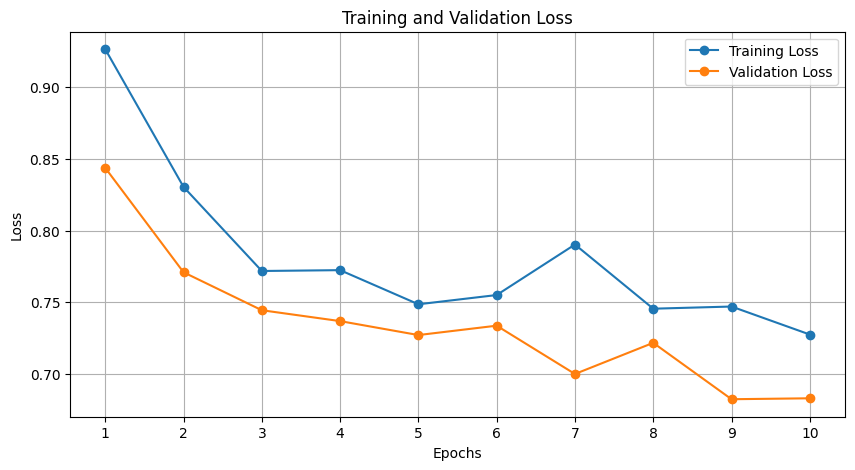

In [5]:
train_model(model1, train_loader, val_loader, num_epochs=10)

### AlexNet

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomAlexNet(nn.Module):
    def __init__(self, dropout_rate):
        super(CustomAlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 5)  # Output layer for 5 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)  # Flatten
        x = self.classifier(x)
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = CustomAlexNet(dropout_rate=0.15).to(device)
print(device)

cuda


Epoch 1/10, Train Loss: 1.2078, Val Loss: 1.0275, Accuracy: 0.4927, Precision: 0.2428, Recall: 0.4927, F1: 0.3253


Epoch 2/10, Train Loss: 0.9736, Val Loss: 0.9673, Accuracy: 0.6236, Precision: 0.4680, Recall: 0.6236, F1: 0.5297


Epoch 3/10, Train Loss: 0.9098, Val Loss: 0.8364, Accuracy: 0.7127, Precision: 0.5728, Recall: 0.7127, F1: 0.6289


Epoch 4/10, Train Loss: 0.8711, Val Loss: 0.8185, Accuracy: 0.7000, Precision: 0.5479, Recall: 0.7000, F1: 0.6132


Epoch 5/10, Train Loss: 0.8301, Val Loss: 0.7983, Accuracy: 0.7018, Precision: 0.5921, Recall: 0.7018, F1: 0.6299


Epoch 6/10, Train Loss: 0.8309, Val Loss: 0.7569, Accuracy: 0.7182, Precision: 0.5805, Recall: 0.7182, F1: 0.6357


Epoch 7/10, Train Loss: 0.8065, Val Loss: 0.7332, Accuracy: 0.7182, Precision: 0.6336, Recall: 0.7182, F1: 0.6582


Epoch 8/10, Train Loss: 0.7505, Val Loss: 0.8111, Accuracy: 0.7145, Precision: 0.6126, Recall: 0.7145, F1: 0.6585


Epoch 9/10, Train Loss: 0.7451, Val Loss: 0.7101, Accuracy: 0.7418, Precision: 0.6561, Recall: 0.7418, F1: 0.6953


Epoch 10/10, Train Loss: 0.7448, Val Loss: 0.7215, Accuracy: 0.7364, Precision: 0.6465, Recall: 0.7364, F1: 0.6878


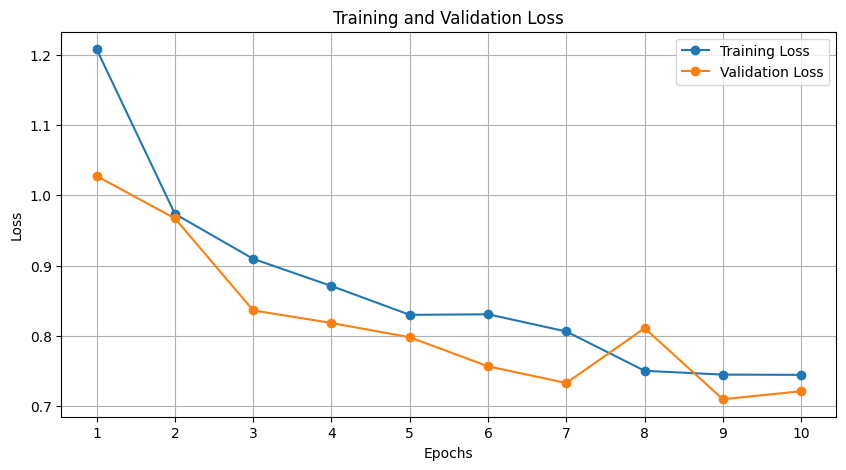

In [7]:
train_model(model2, train_loader, val_loader, num_epochs=10)

#### VGGNet Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomVGG(nn.Module):
    def __init__(self, dropout_rate):
        super(CustomVGG, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(512 * 7 * 7, 4096),  # Adjust based on your input image size
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 5)  # Output layer for 5 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 512 * 7 * 7)  # Flatten
        x = self.classifier(x)
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = CustomVGG(dropout_rate=0.15).to(device)
print(device)

cuda


Epoch 1/10, Train Loss: 1.2831, Val Loss: 1.0939, Accuracy: 0.4927, Precision: 0.2428, Recall: 0.4927, F1: 0.3253


Epoch 2/10, Train Loss: 1.0413, Val Loss: 0.9173, Accuracy: 0.6855, Precision: 0.5591, Recall: 0.6855, F1: 0.6078


Epoch 3/10, Train Loss: 0.9370, Val Loss: 0.9031, Accuracy: 0.6836, Precision: 0.5345, Recall: 0.6836, F1: 0.5985


Epoch 4/10, Train Loss: 0.9283, Val Loss: 1.1683, Accuracy: 0.5745, Precision: 0.4231, Recall: 0.5745, F1: 0.4712


Epoch 5/10, Train Loss: 0.9308, Val Loss: 0.8129, Accuracy: 0.7073, Precision: 0.5515, Recall: 0.7073, F1: 0.6183


Epoch 6/10, Train Loss: 0.8403, Val Loss: 0.8230, Accuracy: 0.7182, Precision: 0.5760, Recall: 0.7182, F1: 0.6335


Epoch 7/10, Train Loss: 0.8147, Val Loss: 0.8274, Accuracy: 0.7164, Precision: 0.5642, Recall: 0.7164, F1: 0.6284


Epoch 8/10, Train Loss: 0.8228, Val Loss: 0.7481, Accuracy: 0.7218, Precision: 0.5762, Recall: 0.7218, F1: 0.6360


Epoch 9/10, Train Loss: 0.8108, Val Loss: 0.7514, Accuracy: 0.7182, Precision: 0.6203, Recall: 0.7182, F1: 0.6627


Epoch 10/10, Train Loss: 0.7731, Val Loss: 0.8197, Accuracy: 0.7200, Precision: 0.6520, Recall: 0.7200, F1: 0.6686


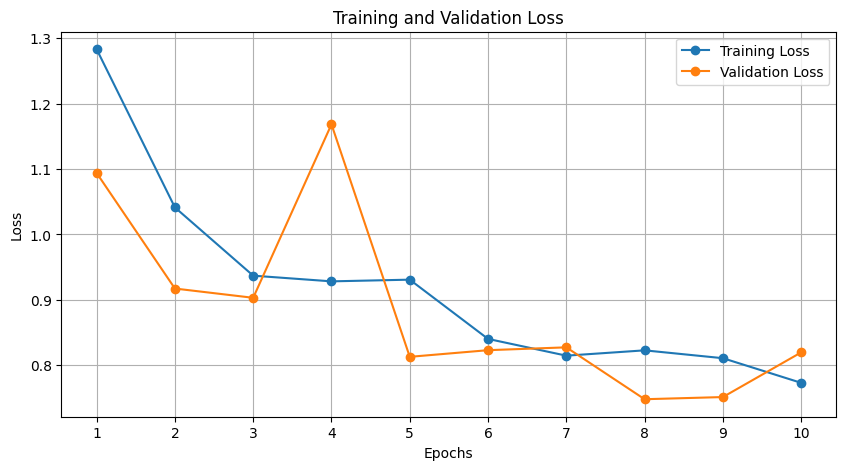

In [9]:
train_model(model3, train_loader, val_loader, num_epochs=10)

### 4. Confusion Matrix

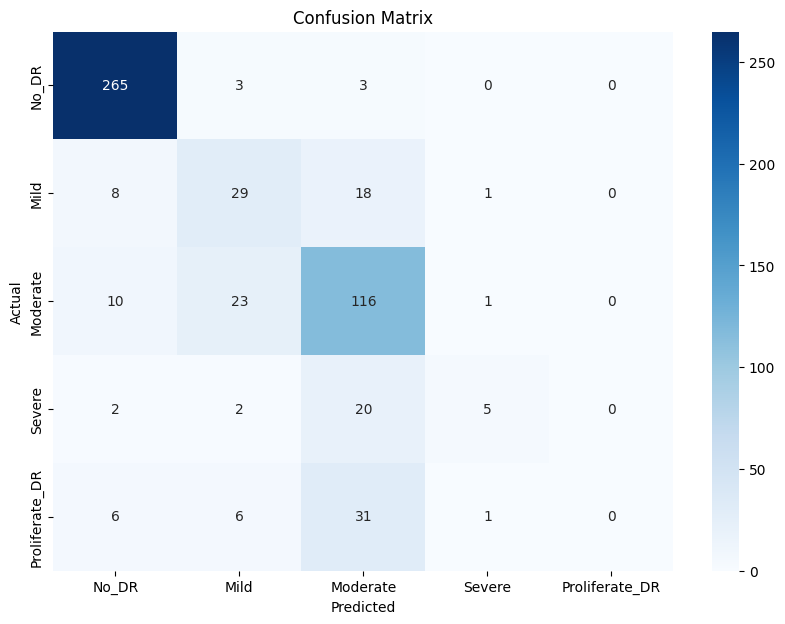

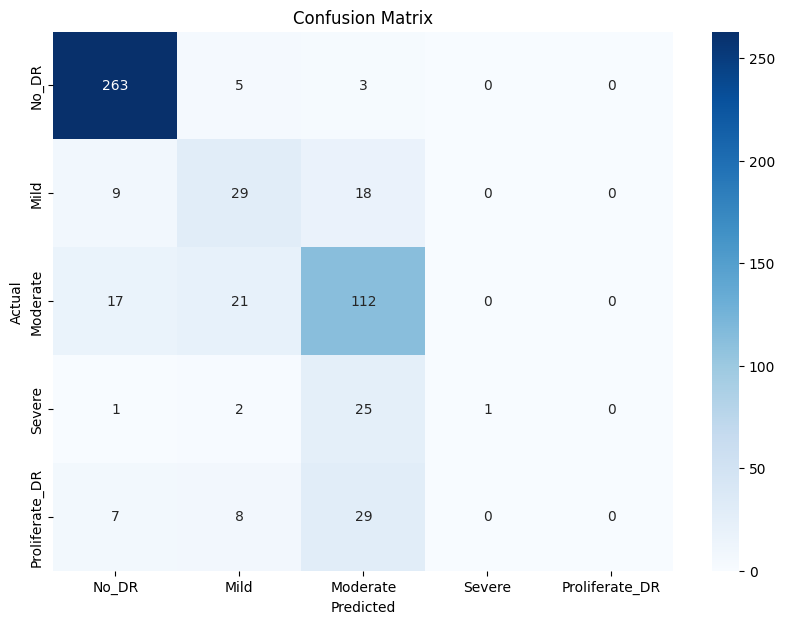

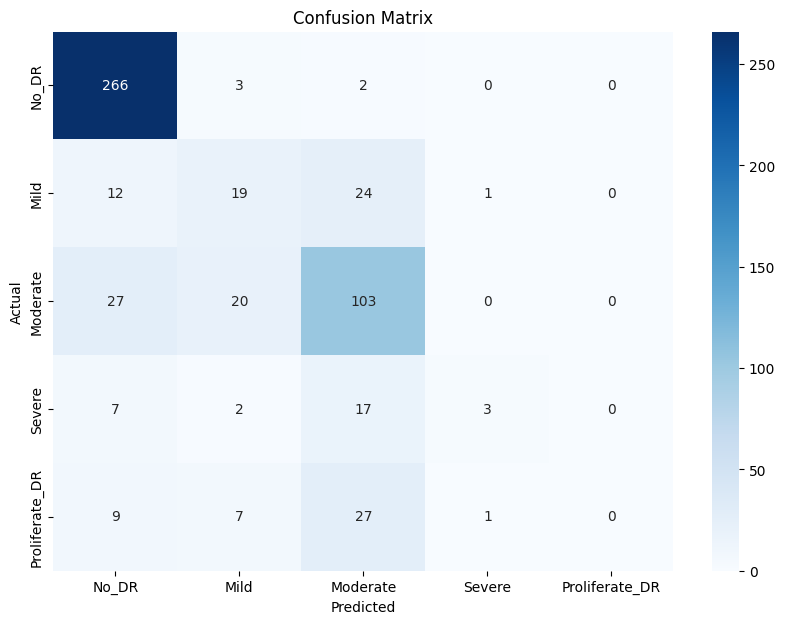

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm

def plot_confusion_matrix(model, val_loader, class_names):
    model.eval()
    
    val_labels, val_preds = [], []
    
    # Validation Loop with Progress Bar
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validating', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, 1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(val_labels, val_preds)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

class_names = list(label_mapping.values())
plot_confusion_matrix(model1, val_loader, class_names)
plot_confusion_matrix(model2, val_loader, class_names)
plot_confusion_matrix(model3, val_loader, class_names)

## Using Binary Classification

### 1. Data Loading and preprocessing

In [13]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from PIL import Image

root_path = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered"

df = pd.read_csv(os.path.join(root_path, 'train.csv'))
root_dir = os.path.join(root_path, 'gaussian_filtered_images', 'gaussian_filtered_images')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [14]:
df['binary_type'].value_counts()

binary_type
DR       1857
No_DR    1805
Name: count, dtype: int64

<Axes: ylabel='binary_type'>

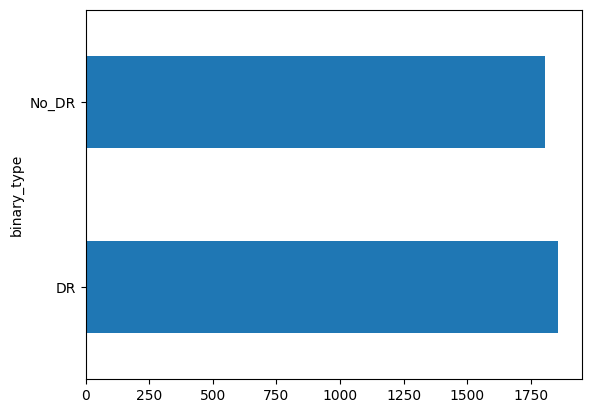

In [15]:
df['binary_type'].value_counts().plot(kind='barh')

In [16]:
df['type'].value_counts()

type
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64

<Axes: ylabel='type'>

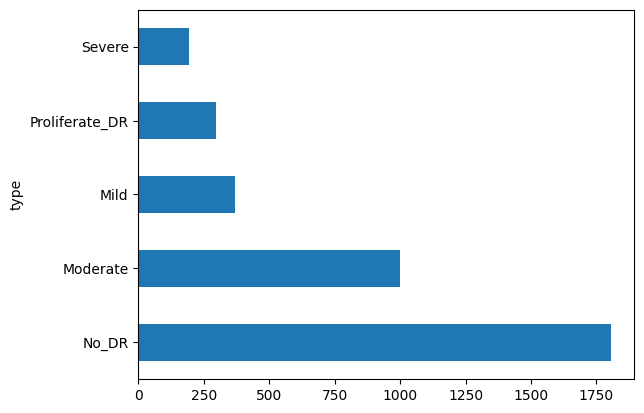

In [17]:
df['type'].value_counts().plot(kind='barh')

In [23]:
label_mapping = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

df['label_folder'] = df['diagnosis'].map(label_mapping)

train_intermediate, val = train_test_split(df, test_size=0.15, stratify=df['diagnosis'])
train, test = train_test_split(train_intermediate, test_size=0.15 / (1 - 0.15), stratify=train_intermediate['diagnosis'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx, 0] + ".png"
        diagnosis = self.df.iloc[idx, 1]
        label_folder = label_mapping[diagnosis]

        img_path = os.path.join(self.root_dir, label_folder, image_id)

        if not os.path.isfile(img_path):
            print(f"File not found: {img_path}")
            raise FileNotFoundError(f"File not found: {img_path}")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, diagnosis

# Create dataset instances
train_dataset = DiabeticRetinopathyDataset(train, root_dir, transform)
val_dataset = DiabeticRetinopathyDataset(val, root_dir, transform)
test_dataset = DiabeticRetinopathyDataset(test, root_dir, transform)

# Function to convert diagnosis labels to binary
def convert_labels_to_binary(dataset):
    binary_labels = []
    for _, diagnosis in dataset:
        binary_label = 0 if diagnosis == 0 else 1
        binary_labels.append(binary_label)
    return binary_labels

# Load train, val, and test data
train_data = [(img, diagnosis) for img, diagnosis in train_dataset]
val_data = [(img, diagnosis) for img, diagnosis in val_dataset]
test_data = [(img, diagnosis) for img, diagnosis in test_dataset]

# Convert labels to binary
train_labels_binary = convert_labels_to_binary(train_data)
val_labels_binary = convert_labels_to_binary(val_data)
test_labels_binary = convert_labels_to_binary(test_data)

# Create DataLoaders using the images and binary labels
train_loader = DataLoader([(img, label) for (img, _), label in zip(train_data, train_labels_binary)], batch_size=64, shuffle=True)
val_loader = DataLoader([(img, label) for (img, _), label in zip(val_data, val_labels_binary)], batch_size=64, shuffle=False)
test_loader = DataLoader([(img, label) for (img, _), label in zip(test_data, test_labels_binary)], batch_size=64, shuffle=False)

### 2. CustomCNN Model

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding='valid')  # input_shape=(224,224,3)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding='valid')
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 4), padding='valid')
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn3 = nn.BatchNorm2d(32)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 25 * 25, 32)  # Adjust based on input size after convolutions
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 2)  # Output for 2 classes

    def forward(self, x):
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = self.pool3(self.bn3(F.relu(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(dropout_rate=0.15).to(device)

### 3. Training and Evaluation

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.optim as optim
from tqdm import tqdm 

def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=loss.item())

        model.eval()
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(val_labels, val_preds)
        prec = precision_score(val_labels, val_preds, average='weighted')
        rec = recall_score(val_labels, val_preds, average='weighted')
        f1 = f1_score(val_labels, val_preds, average='weighted')

        print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}')

In [26]:
train_model(model, train_loader, val_loader)

Epoch 1/10: 100%|██████████| 41/41 [00:02<00:00, 16.74batch/s, loss=1.15] 


Epoch 1/10, Accuracy: 0.6655, Precision: 0.7786, Recall: 0.6655, F1: 0.6251


Epoch 2/10: 100%|██████████| 41/41 [00:02<00:00, 17.14batch/s, loss=0.0353]


Epoch 2/10, Accuracy: 0.9255, Precision: 0.9256, Recall: 0.9255, F1: 0.9255


Epoch 3/10: 100%|██████████| 41/41 [00:02<00:00, 17.26batch/s, loss=0.554] 


Epoch 3/10, Accuracy: 0.8655, Precision: 0.8854, Recall: 0.8655, F1: 0.8640


Epoch 4/10: 100%|██████████| 41/41 [00:02<00:00, 16.24batch/s, loss=0.000344]


Epoch 4/10, Accuracy: 0.9509, Precision: 0.9511, Recall: 0.9509, F1: 0.9509


Epoch 5/10: 100%|██████████| 41/41 [00:02<00:00, 17.22batch/s, loss=0.00505]


Epoch 5/10, Accuracy: 0.9509, Precision: 0.9514, Recall: 0.9509, F1: 0.9509


Epoch 6/10: 100%|██████████| 41/41 [00:02<00:00, 16.90batch/s, loss=0.237] 


Epoch 6/10, Accuracy: 0.9509, Precision: 0.9510, Recall: 0.9509, F1: 0.9509


Epoch 7/10: 100%|██████████| 41/41 [00:02<00:00, 17.14batch/s, loss=0.0113]


Epoch 7/10, Accuracy: 0.9509, Precision: 0.9511, Recall: 0.9509, F1: 0.9509


Epoch 8/10: 100%|██████████| 41/41 [00:02<00:00, 17.05batch/s, loss=0.0213]


Epoch 8/10, Accuracy: 0.9327, Precision: 0.9343, Recall: 0.9327, F1: 0.9326


Epoch 9/10: 100%|██████████| 41/41 [00:02<00:00, 17.16batch/s, loss=0.0143] 


Epoch 9/10, Accuracy: 0.9527, Precision: 0.9528, Recall: 0.9527, F1: 0.9527


Epoch 10/10: 100%|██████████| 41/41 [00:02<00:00, 17.08batch/s, loss=0.00931]


Epoch 10/10, Accuracy: 0.9473, Precision: 0.9490, Recall: 0.9473, F1: 0.9472


### 4. Confusion matrix and Visualization

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

def visualize_predictions(model, data_loader, class_names, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title(f'Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}')
        plt.axis('off')
    plt.show()

### 5. Hyperparameter tuning

In [28]:
import numpy as np
from sklearn.metrics import accuracy_score
from itertools import product

learning_rates = [1e-4, 1e-3]
batch_sizes = [32, 64]
num_epochs_list = [10, 15]
dropout_rates = [0.1, 0.2]

def train_with_hyperparameters(learning_rate, batch_size, num_epochs, dropout_rate):
    model = CustomCNN(dropout_rate).to(device)
    train_loader = DataLoader([(img, label) for (img, _), label in zip(train_data, train_labels_binary)],
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader([(img, label) for (img, _), label in zip(val_data, val_labels_binary)],
                            batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    val_labels, val_preds = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(val_labels, val_preds)
    return acc

best_acc = 0
best_params = {}

for learning_rate, batch_size, num_epochs, dropout_rate in product(learning_rates, batch_sizes, num_epochs_list, dropout_rates):
    print(f'Testing learning_rate={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs}, dropout_rate={dropout_rate}')
    acc = train_with_hyperparameters(learning_rate, batch_size, num_epochs, dropout_rate)
    print(f'Accuracy: {acc:.4f}')

    if acc > best_acc:
        best_acc = acc
        best_params = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'dropout_rate': dropout_rate
        }

print(f'Best Accuracy: {best_acc:.4f} with parameters: {best_params}')

Testing learning_rate=0.0001, batch_size=32, num_epochs=10, dropout_rate=0.1
Accuracy: 0.9418
Testing learning_rate=0.0001, batch_size=32, num_epochs=10, dropout_rate=0.2
Accuracy: 0.9491
Testing learning_rate=0.0001, batch_size=32, num_epochs=15, dropout_rate=0.1
Accuracy: 0.9473
Testing learning_rate=0.0001, batch_size=32, num_epochs=15, dropout_rate=0.2
Accuracy: 0.9436
Testing learning_rate=0.0001, batch_size=64, num_epochs=10, dropout_rate=0.1
Accuracy: 0.9473
Testing learning_rate=0.0001, batch_size=64, num_epochs=10, dropout_rate=0.2
Accuracy: 0.9345
Testing learning_rate=0.0001, batch_size=64, num_epochs=15, dropout_rate=0.1
Accuracy: 0.9400
Testing learning_rate=0.0001, batch_size=64, num_epochs=15, dropout_rate=0.2
Accuracy: 0.9509
Testing learning_rate=0.001, batch_size=32, num_epochs=10, dropout_rate=0.1
Accuracy: 0.9364
Testing learning_rate=0.001, batch_size=32, num_epochs=10, dropout_rate=0.2
Accuracy: 0.9418
Testing learning_rate=0.001, batch_size=32, num_epochs=15, dro

### 6. Final Model

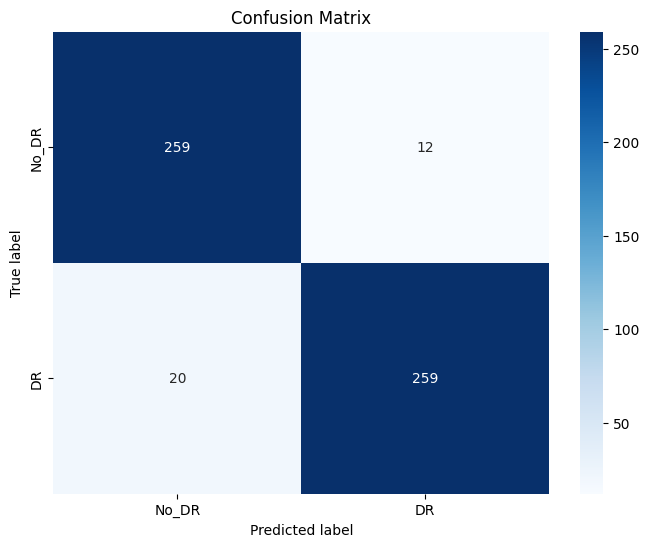

Final Validation Accuracy: 0.9418
Model saved to diabetic_retinopathy_model.pth


In [29]:
def train_final_model(best_params):
    model = CustomCNN(best_params['dropout_rate']).to(device)
    train_loader = DataLoader([(img, label) for (img, _), label in zip(train_data, train_labels_binary)],
                              batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader([(img, label) for (img, _), label in zip(val_data, val_labels_binary)],
                            batch_size=best_params['batch_size'], shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

    for epoch in range(best_params['num_epochs']):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    val_labels, val_preds = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(val_labels, val_preds)
    plot_confusion_matrix(val_labels, val_preds, ["No_DR", "DR"])
    print(f'Final Validation Accuracy: {acc:.4f}')

    model_path = 'diabetic_retinopathy_model.pth'
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

train_final_model(best_params)

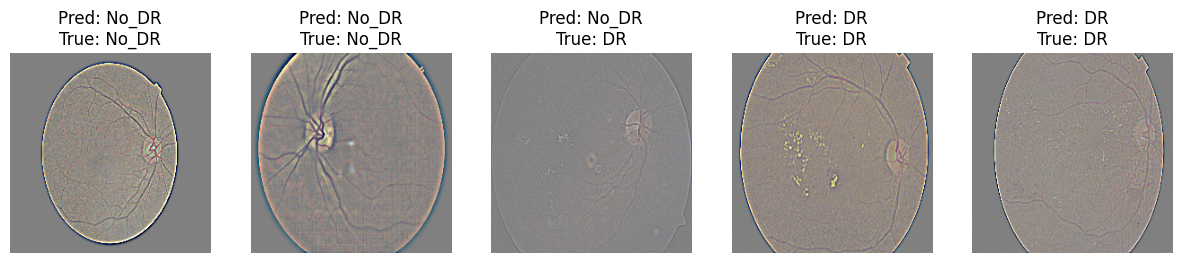

In [32]:
visualize_predictions(model, test_loader, ["No_DR", "DR"], num_images=5)